# Introduction
In this notebook, we will be using the MNIST dataset to classify images of handwritten digits.
We will be using a MLP (Multi-Layer Perceptron) to classify the images.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as transforms

## Load Data

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True)

X_train, y_train = train_set.data.numpy(), train_set.targets.numpy()
X_test, y_test = test_set.data.numpy(), test_set.targets.numpy()

Since the data contains images, we will visualize a few images to get a better understanding of the data.

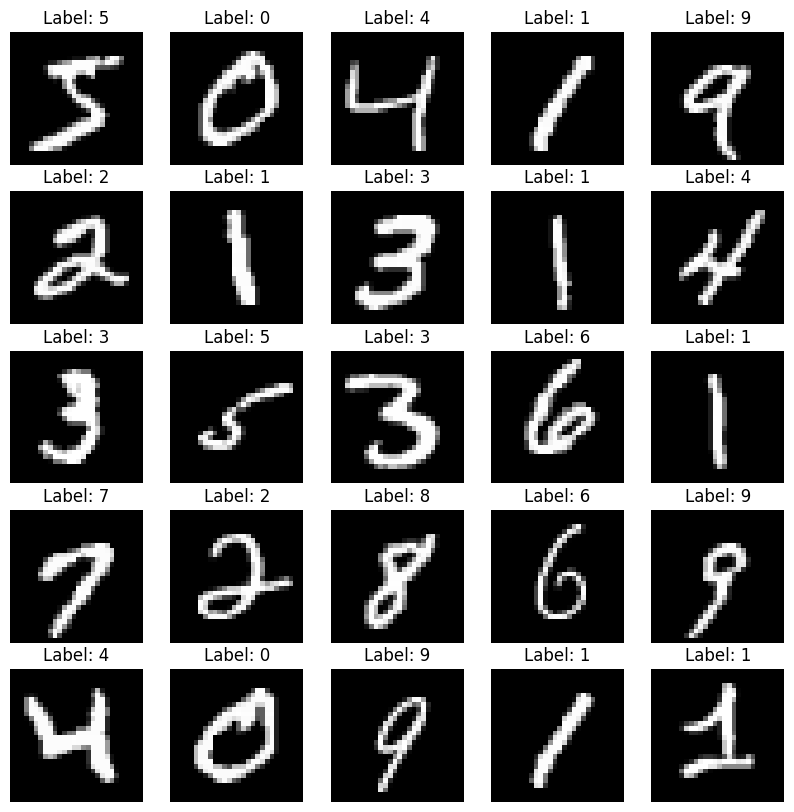

In [3]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.show()

We will split the training data into training and validation sets.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

## Prepare Data for Training
The data is in the form of images and a label for each image. We will need to flatten the images and normalize the pixel values in order to train the model.

In [5]:
X_train, X_val, X_test = X_train/255, X_val/255, X_test/255
X_train, X_val, X_test = X_train.reshape(X_train.shape[0], -1), X_val.reshape(X_val.shape[0], -1), X_test.reshape(X_test.shape[0], -1)

## Model
We will now try to make our MLP model. This model has one input layer, three hidden layers, and one output layer.
In the next cell, we define the architecture of our model and initialize its weights and biases. The variables are as follows:
- `input_size`: Represents the number of neurons in the input layer which is equal to the number of features in the input data.
- `hidden_sizes`: Represents the number of neurons in each hidden layer of the model and is equal to [256, 128, 64].
- `output_size`: Represents the number of neurons in the output layer which is equal to the number of classes in the output data (10). 

In [6]:
from torch import nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.layers = nn.ModuleList()
        
        # Input Layer
        self.layers.append(nn.Sequential(nn.Linear(self.input_size, self.hidden_sizes[0]), nn.ReLU()))
        
        # Hidden Layers
        for i in range(len(self.hidden_sizes)-1):
            self.layers.append(nn.Sequential(nn.Linear(self.hidden_sizes[i], self.hidden_sizes[i+1]), nn.ReLU()))
            
        # Output Layer
        self.layers.append(nn.Sequential(nn.Linear(self.hidden_sizes[-1], self.output_size), nn.Softmax()))

        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, lr, verbose=False):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        for epoch in range(epochs):
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.long)
                
                optimizer.zero_grad()
                y_pred = self.forward(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                
            if verbose:
                y_pred = self.forward(torch.tensor(X_val, dtype=torch.float32))
                val_loss = criterion(y_pred, torch.tensor(y_val, dtype=torch.long))
                print(f'Epoch: {epoch+1}, Validation Loss: {val_loss.item()}')       

In [7]:
input_size = X_train.shape[1]
hidden_sizes = [256, 128, 64]
output_size = 10

## Training
In the next cell, we will train our model on the training data and validate it on the validation data. 

In [8]:
model = MLP(input_size, hidden_sizes, output_size)
model.train(X_train, y_train, X_val, y_val, epochs=10, batch_size=32, lr=0.001, verbose=True)

C:\Users\RSKALA\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 1, Validation Loss: 1.5316872596740723
Epoch: 2, Validation Loss: 1.5273579359054565
Epoch: 3, Validation Loss: 1.5066297054290771
Epoch: 4, Validation Loss: 1.5018789768218994
Epoch: 5, Validation Loss: 1.5314550399780273
Epoch: 6, Validation Loss: 1.4981671571731567
Epoch: 7, Validation Loss: 1.5004980564117432
Epoch: 8, Validation Loss: 1.49625563621521
Epoch: 9, Validation Loss: 1.5037058591842651
Epoch: 10, Validation Loss: 1.494971513748169


## Evaluation
We will now evaluate our model on the test data and calculate the accuracy of the model.

In [9]:
from sklearn.metrics import accuracy_score

y_pred = model.forward(torch.tensor(X_test, dtype=torch.float32))
y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy: {:.2f}%'.format(100*accuracy))

Test Accuracy: 96.55%


# Visualizing Predictions and their true labels
We will now visualize a few predictions made by the model and compare them with the true labels of the images.

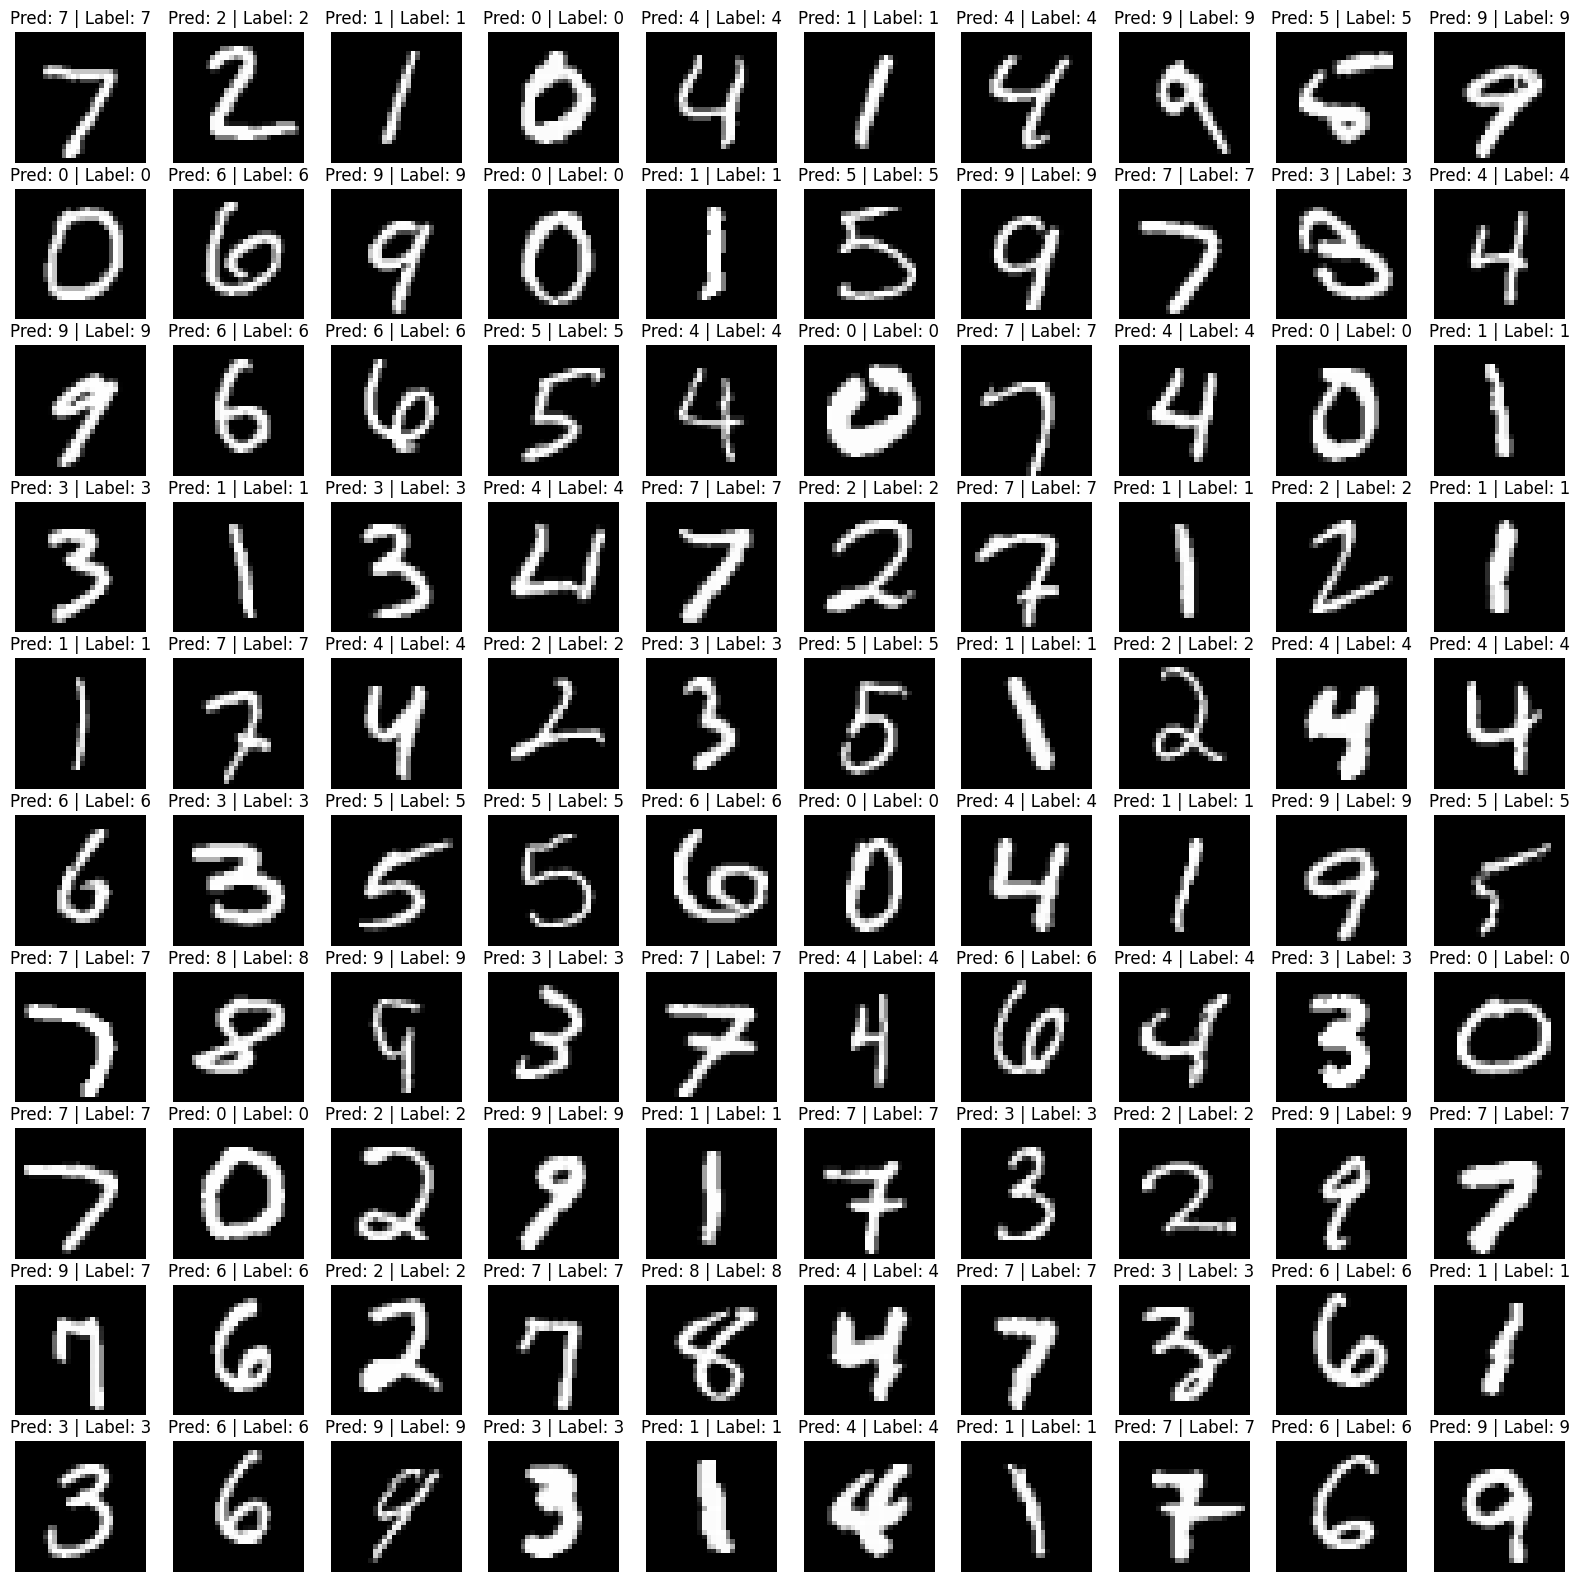

In [10]:
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {y_pred[i]} | Label: {y_test[i]}')
    plt.axis('off')
plt.show()

# Conclusion
In this notebook, we used the MNIST dataset to classify images of handwritten digits using an MLP model. We achieved a test accuracy of 96.6%.